In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
from scipy.stats import beta

In [2]:
plt.rc('font', size=12)

In [3]:
#data path
data_path  = "/data/streams.csv"

df_all = pd.read_csv(data_path) 

In [4]:
#if there are duplicated interactions, for those we get the ones with the longest listening time
df = df_all.groupby(['user_id','ts_listen','track_id'])['ts_listen'].count().reset_index(name = 'duplicates')

#these are good to go
df1 = df_all.merge(df[df.duplicates ==1][['user_id','track_id','ts_listen']], on  = ['user_id','track_id','ts_listen'])

#these are the ones with duplicates
df2 = df_all.merge(df[df.duplicates >1][['user_id','track_id','ts_listen']], on  = ['user_id','track_id','ts_listen'])

df = df2.groupby(['user_id','track_id','ts_listen'])['listening_time'].max().reset_index()
df2 = df2.merge(df, on = ['user_id','track_id','ts_listen','listening_time'])

df_all = pd.concat([df1,df2])

In [5]:
#drop the rows with listening time inferior to 0
df_all = df_all[df_all.listening_time >=0].copy()

In [6]:
df_all.sort_values(by = 'ts_listen', inplace = True)
df_all.reset_index(drop = True, inplace = True)

In [7]:
df = df_all.copy()

In [8]:
#add time since last listen, or recency
df['end_song'] = df['ts_listen'] #+ df['listening_time'] 
df['last_y_eq_1'] = df['end_song'].where(df['y'] == 1)

# Group by ['user_id', 'track_id'] and forward-fill the last timestamp where y == 1
df['last_y_eq_1'] = df.groupby(['user_id', 'track_id'])['last_y_eq_1'].ffill()

# Shift the last_y_eq_1 by one period within each group to get the previous timestamp
df['last_y_eq_1'] = df.groupby(['user_id', 'track_id'])['last_y_eq_1'].shift()

# Calculate the time difference
df['time_diff'] = df['ts_listen'] - df['last_y_eq_1']

In [9]:
#here we consider the behavior for time differences superior to 134s, which is the lower end of the track duration in our data
df = df[(df['time_diff'] >= 134) | (df['time_diff'].isna())]

In [10]:
#add variables such as time difference or number of LEs
df.sort_values(by=['ts_listen'], inplace = True)
df.reset_index(inplace = True, drop = True)
df['n_listen'] = df.groupby(['user_id','track_id'])['y'].transform('cumsum')

df['listen_count'] = df.groupby(['user_id','track_id'])['n_listen'].shift(periods=1, fill_value=0)
temp = df.groupby(['user_id','track_id'])['y'].sum().reset_index(name = 'total_rep')
df = df.merge(temp, on = ['user_id','track_id'])

temp = df.groupby(['user_id','track_id'])['y'].count().reset_index(name = 'total_int')
df = df.merge(temp, on = ['user_id','track_id'])

In [11]:
#for playcount, we get the first interaction after the last LE
temp = df.groupby(['user_id','track_id','listen_count'])['ts_listen'].min().reset_index()

df1 = df.merge(temp, on = ['user_id','track_id','listen_count','ts_listen'])


###################### Uncertainty over play count ###################### 

In [12]:
#for play count analysis we remove the pairs user-items whose single interaction was a LE
df1 = df1[(df1.total_int >1)&(df1.total_rep <=73)].copy()

In [13]:
temp = df1.groupby('listen_count')['ts_listen'].count().reset_index()
x_count = temp.values[:,0]
y_count = temp.values[:,1]

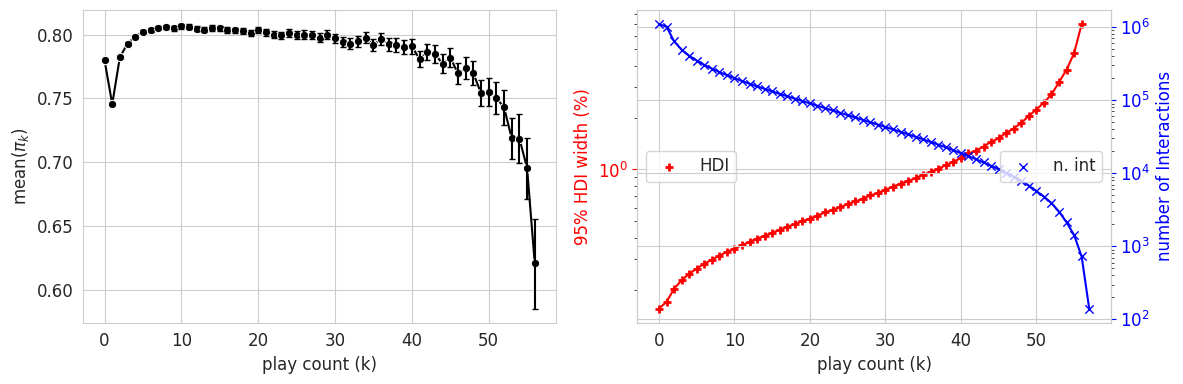

In [14]:
temp1 = df1[df1.y == 1].groupby('listen_count')['ts_listen'].count().reset_index(name = 'successes')
temp2 = df1[df1.y == 0].groupby('listen_count')['ts_listen'].count().reset_index(name = 'failures')

data = temp1.merge(temp2, on = 'listen_count')

xs = []
means = []
stds = []
upper = []
lower= []

prior = 5

for index, row in data.iterrows():
    a = prior + row['successes']
    b = prior + row['failures']

    xs.append(index)
    means.append(beta.mean(a, b, loc=0, scale=1))
    stds.append(beta.std(a, b, loc=0, scale=1))
    lower.append(beta.interval(0.95, a, b, loc=0, scale=1)[0])
    upper.append(beta.interval(0.95, a, b, loc=0, scale=1)[1])

means = np.array(means)
stds = np.array(stds)
lower = np.array(lower)
upper = np.array(upper)
CIw = (upper - lower)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax = sns.lineplot(x = xs, y = means, color = 'black', ax = axs[0],linestyle='-', marker = 'o')
#ax = sns.scatterplot(x = xs, y = means, color = 'black', linewidth=0, ax = axs[0], marker ='')

upper_error = upper - means
lower_error = means - lower

# Add error bars using errorbar function
axs[0].errorbar(x=xs, y=means, yerr=[lower_error, upper_error], fmt='none', capsize=2, c = 'black')


ax = sns.lineplot(x = xs, y = 100*CIw, color = 'red', ax = axs[1])
ax = sns.scatterplot(x = xs, y = 100*CIw, color = 'red', marker = '+', linewidth=2, ax = axs[1], label = 'HDI')

ax2 = axs[1].twinx()

ax2 = sns.scatterplot(x=x_count, y=y_count, c = 'blue',ax = ax2, marker = 'x',  linewidth=1, label = 'n. int')
ax2 = sns.lineplot(x=x_count, y=y_count, c = 'blue',ax = ax2)

ax2.set_ylabel('number of Interactions', color='blue')

axs[1].set_yscale('log')
ax2.set_yscale('log')

axs[1].tick_params(axis='y', colors='red')
ax2.tick_params(axis='y', colors='blue')


axs[0].set_xlabel('play count (k)')
axs[0].set_ylabel('mean($\pi_k$)')
axs[1].set_xlabel('play count (k)')
axs[1].set_ylabel('95% HDI width (%)', color='red')

axs[1].legend(loc = "center left")
ax2.legend(loc = "center right")

plt.tight_layout()
#plt.savefig("expected_playcount.pdf", bbox_inches='tight')

###################### Uncertainty over recency ######################

In [15]:
df['time_diff_h'] = df['time_diff']/3600
df['log_time'] = df['time_diff_h'].apply(np.log10)

df1 = df[(df.time_diff >0)&(df.total_rep <=73)].copy()

In [16]:
time_data = df1['time_diff']

n_bins = 100  #adjust this based on how granular you want it
# Create logarithmically spaced bins
log_bins = np.logspace(np.log10(time_data.min()), np.log10(time_data.max()), n_bins)
# Use cut to bin the data based on the logarithmic bins
df1['diff_range'] = pd.cut(time_data, bins=log_bins, labels=False, include_lowest=True)

In [17]:
temp1 = df1[df1.y == 1].groupby('diff_range')['ts_listen'].count().reset_index(name = 'successes')
temp2 = df1[df1.y == 0].groupby('diff_range')['ts_listen'].count().reset_index(name = 'failures')
temp3 = df1.groupby('diff_range')['time_diff'].mean().reset_index(name = 'median_diff')


data = temp1.merge(temp2, on = 'diff_range')
data = data.merge(temp3, on = 'diff_range')

In [18]:
labels = np.arange(1,n_bins+1)
time_labels = labels
gaps = pd.cut(df1.time_diff, n_bins, labels = time_labels)
df1['lin_diff_range'] = gaps
temp = df1.groupby('diff_range')['time_diff'].agg(['mean','count']).reset_index()
x_count = temp.values[:,1]
y_count = temp.values[:,2]

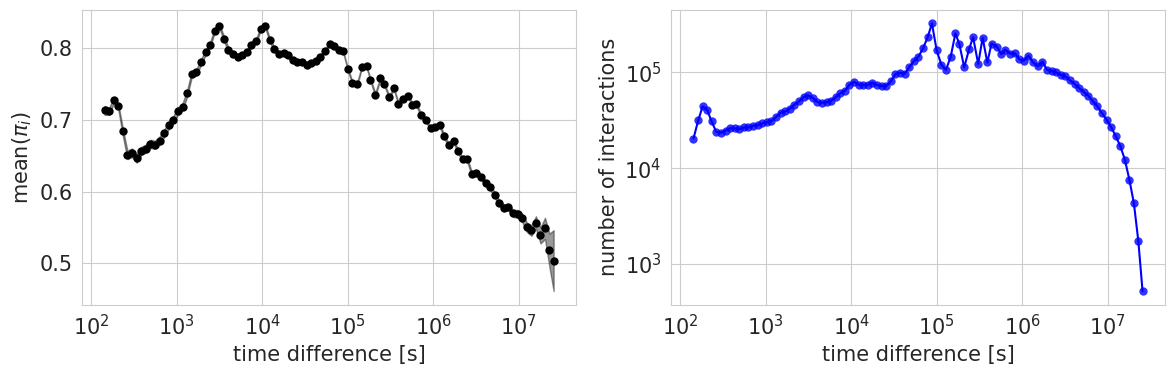

In [19]:
plt.rc('font', size=15)
xs = []
means = []
stds = []
upper = []
lower= []

prior = 5

for index, row in data.iterrows():
    a = prior + row['successes']
    b = prior + row['failures']

    xs.append(row['median_diff'])
    means.append(beta.mean(a, b, loc=0, scale=1))
    stds.append(beta.std(a, b, loc=0, scale=1))
    lower.append(beta.interval(0.95, a, b, loc=0, scale=1)[0])
    upper.append(beta.interval(0.95, a, b, loc=0, scale=1)[1])



means = np.array(means)
stds = np.array(stds)
lower = np.array(lower)
upper = np.array(upper)
CIw = (upper - lower)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))


ax = sns.scatterplot(x = xs, y = means, color = 'black', ax = axs[0],linewidth=0)

upper_error = upper - means
lower_error = means - lower

axs[0].fill_between(x=xs, y1= lower, y2 = upper, color = 'black', alpha = 0.4)

sns.scatterplot(x = x_count, y = y_count, color = 'blue', ax = axs[1], marker = 'o', linewidth = 0, alpha = 0.8)
sns.lineplot(x = x_count, y = y_count, color = 'blue', ax = axs[1])

axs[0].set(xscale='log')
axs[0].set(xscale='log')


axs[1].set(xscale='log')
axs[1].set(yscale='log')


axs[0].set_xlabel('time difference [s]')
axs[0].set_ylabel('mean($\pi_i$)')
axs[1].set_xlabel('time difference [s]')
axs[1].set_ylabel('number of interactions')
plt.tight_layout()

In [20]:
###################### Uncertainty over playcount x recency ######################

In [21]:
time_data = df1['time_diff']

n_bins = 100#50  # You can adjust this based on how granular you want it

# Create logarithmically spaced bins
log_bins = np.logspace(np.log10(time_data.min()), np.log10(time_data.max()), n_bins)

# Use pandas.cut to bin the data based on the logarithmic bins
df1['diff_range'] = pd.cut(time_data, bins=log_bins, labels=False, include_lowest=True)


In [27]:
temp1 = df1[df1.y == 1].groupby(['listen_count','diff_range'])['ts_listen'].count().reset_index(name = 'successes')
temp2 = df1[df1.y == 0].groupby(['listen_count','diff_range'])['ts_listen'].count().reset_index(name = 'failures')
temp3 = df1.groupby('diff_range')['time_diff'].mean().reset_index(name = 'median_diff')


data = temp1.merge(temp2, on = ['listen_count','diff_range'])
data = data.merge(temp3, on = 'diff_range')

In [28]:
data['total'] = data['successes'] + data['failures']

In [29]:
playcount = []
time_diff = []
means = []
stds = []
upper = []
lower= []

#compute the posterior distribution
for index, row in data.iterrows():
    a = 200 + row['successes']
    b = 200 + row['failures']

    playcount.append(row['listen_count'])
    time_diff.append(row['median_diff'])
    means.append(beta.mean(a, b, loc=0, scale=1))
    stds.append(beta.std(a, b, loc=0, scale=1))
    lower.append(beta.interval(0.95, a, b, loc=0, scale=1)[0])
    upper.append(beta.interval(0.95, a, b, loc=0, scale=1)[1])
    
    
data = pd.DataFrame({'listen_count': playcount, 'time_diff':time_diff, 'listen_prob':means, 'upper':upper,'lower':lower})
data['CIw'] = data['upper'] - data['lower']

data.dropna(inplace = True)

/tmp/ipykernel_2096327/4042270881.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


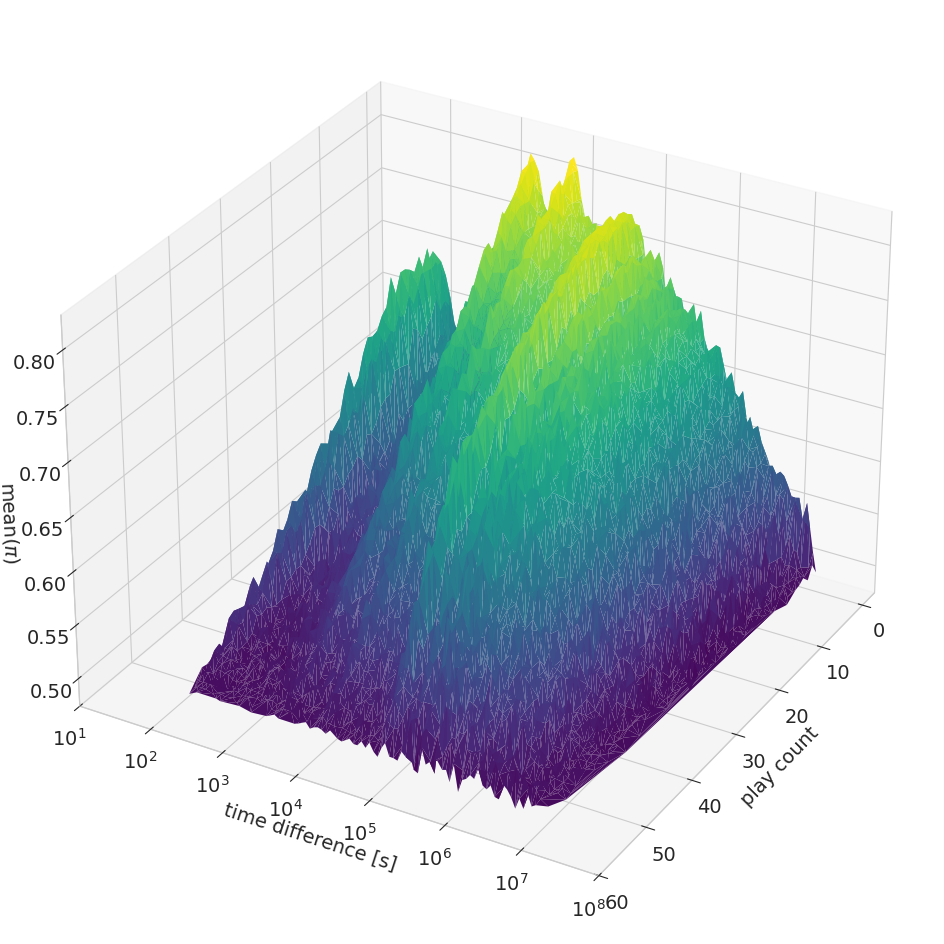

In [30]:
plt.rc('font', size=14)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

x = data['listen_count']
y= np.log10(data['time_diff'])
z = data['listen_prob']

ax.plot_trisurf(x, y, z, edgecolor='none',cmap='viridis',linewidth=0,rasterized=True)#surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap='Blues')

y_ticks_log = ax.get_yticks()  # Get current x ticks in log10(x)
y_ticks_actual = ['$10**tick$' for tick in y_ticks_log]  # Convert log10(x) to x
ax.set_yticks(y_ticks_log)  # Set the positions (same as before)
ax.set_yticklabels([f"$10^{{{int(tick)}}}$" for tick in y_ticks_log])

ax.set_xlabel('play count')
ax.set_ylabel('time difference [s]')  
ax.set_zlabel('mean($\pi$)')

# adjust the viewing angle
ax.view_init(elev=30, azim= 30)

plt.tight_layout()